In [1]:
from aiida import load_profile
import typing as t
import json

load_profile("2023-08-07")

from aiida import orm
from aiida_sssp_workflow.calculations.calculate_metric import rel_errors_vec_length

In [5]:
def get_conv_data(i_para, r_para) -> t.Tuple[float, float, float]:
    """Return AE_delta (per atom), AE_nu, REL_nu (the nu compare to the reference not to AE)"""
    AE_delta = i_para['delta/natoms']
    AE_nu = i_para['rel_errors_vec_length']
    
    REFE_delta = r_para['delta/natoms']
    REFE_nu = r_para['rel_errors_vec_length']
    
    AE_delta_abs_diff = abs(AE_delta - REFE_delta)
    AE_nu_abs_diff = abs(AE_nu - REFE_nu)
    
    ref_V0, ref_B0, ref_B1 = r_para['birch_murnaghan_results']
    V0, B0, B1 = i_para['birch_murnaghan_results']

    RELA_nu = rel_errors_vec_length(ref_V0, ref_B0, ref_B1, V0, B0, B1)

    return AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu

In [6]:
def plot_compare_extract(pk):
    node = orm.load_node(pk)
    for wf in node.called:
        if wf.process_label == 'ConvergenceDeltaWorkChain':
            lst = []
            for wf2 in wf.called:

                if wf2.process_label == 'helper_delta_difference':
                    lst.append(wf2)
                if wf2.process_label == 'convergence_analysis':
                    break
        
        else:
            # parse_pseudo_info or _CachingConvergenceWorkChain
            continue
        
    scan_list = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 150, 200]
    data = {}
    if len(lst) != len(scan_list):
        return None
    for i, wf in enumerate(lst):
        cutoff = scan_list[i]

        i_para = wf.inputs.input_parameters.get_dict()
        r_para = wf.inputs.ref_parameters.get_dict()
    
        AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu = get_conv_data(i_para, r_para)
        data[cutoff] = {
            "AE_delta": AE_delta_abs_diff,
            "AE_nu_diff": AE_nu_abs_diff,
            "RELA_nu": RELA_nu,
            "plot_info": {
                "AE_ref": wf.inputs.ref_parameters.get_dict()['reference_ae_V0_B0_B1'],
                "ref_200": wf.inputs.ref_parameters.get_dict()['birch_murnaghan_results'],
                "cutoff_eos": wf.inputs.input_parameters.get_dict()['birch_murnaghan_results'],
            }
        }

    # Get the converge value of AE_nu_diff < 0.01
    max_cutoff = 200
    for cutoff in reversed(scan_list):
        try: 
            ae_diff = data[cutoff]['AE_nu_diff']
        except:
            continue
        
        if ae_diff > 0.01:
            break

        max_cutoff = cutoff
        
    return data[max_cutoff]['plot_info']

In [27]:
import numpy as np

def birch_murnaghan(V, E0, V0, B0, B01):
    """
    Return the energy for given volume (V - it can be a vector) according to
    the Birch Murnaghan function with parameters E0,V0,B0,B01.
    """
    r = (V0 / V) ** (2.0 / 3.0)
    return E0 + 9.0 / 16.0 * B0 * V0 * (
        (r - 1.0) ** 3 * B01 + (r - 1.0) ** 2 * (6.0 - 4.0 * r)
    )

def eos_plot(
    ax, ref_ae_data, ref_data, line_data, title="EOS compare", fontsize=8
):
    """plot EOS result on ax"""

    ref_ae_V0, ref_ae_B0, ref_ae_B01 = ref_ae_data
    ref_V0, ref_B0, ref_B01 = ref_data
    V0, B0, B01 = line_data

    v_mid = ref_ae_V0

    dense_volume_min = v_mid - 0.1 * v_mid
    dense_volume_max = v_mid + 0.1 * v_mid

    dense_volumes = np.linspace(dense_volume_min, dense_volume_max, 100)

    energy0 = 0.0

    ae_eos_fit_energy = birch_murnaghan(
        V=dense_volumes,
        E0=energy0,  # in future update E0 from referece json, where ACWF has E0 stored.
        V0=ref_ae_V0,
        B0=ref_ae_B0,
        B01=ref_ae_B01,
    )
    ref_eos_fit_energy = birch_murnaghan(
        V=dense_volumes,
        E0=energy0,
        V0=ref_V0,
        B0=ref_B0,
        B01=ref_B01,
    )
    line_eos_fit_energy = birch_murnaghan(
        V=dense_volumes,
        E0=energy0,
        V0=V0,
        B0=B0,
        B01=B01,
    )

    # Plot EOS
    ax.tick_params(axis="y", labelsize=6, rotation=45)

    # AE
    ax.plot(dense_volumes, ae_eos_fit_energy, "--r", label="AE")
    ax.axvline(V0, linestyle="--", color="gray")

    # ref
    ax.plot(dense_volumes, ref_eos_fit_energy, "--g", label="Ref", alpha=0.5)

    # line
    ax.plot(dense_volumes, line_eos_fit_energy, ":b", label=f"At cutoff", alpha=0.5)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), fontsize=fontsize)
    ax.set_xlabel("Cell volume per formula unit ($\\AA^3$)", fontsize=fontsize)
    ax.set_ylabel("$E - TS$ (eV)", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=fontsize)

    return ax

{'AE_ref': [6.8311116561704, 0.57091332636343, 3.1806650492089],
 'cutoff_eos': [6.8290015, 0.5706014, 3.1795742],
 'ref_200': [6.828975, 0.5702999, 3.1730885]}


<Axes: title={'center': 'Type-A EOS'}, xlabel='Cell volume per formula unit ($\\AA^3$)', ylabel='$E - TS$ (eV)'>

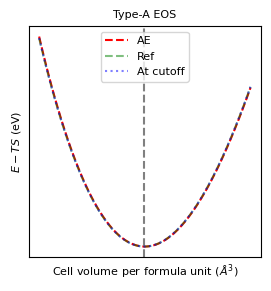

In [36]:
# type-A
import matplotlib.pyplot as plt
from pprint import pprint

A_node = orm.load_node(2274262)
data_plot = plot_compare_extract(A_node.pk)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
pprint(data_plot)
eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-A EOS")

{'AE_ref': [48.562119426851, 0.27405041604935, 3.539614935586],
 'cutoff_eos': [48.8108279, 0.2762983, 3.555167],
 'ref_200': [48.8072757, 0.2762859, 3.5509742]}


<Axes: title={'center': 'Type-A EOS'}, xlabel='Cell volume per formula unit ($\\AA^3$)', ylabel='$E - TS$ (eV)'>

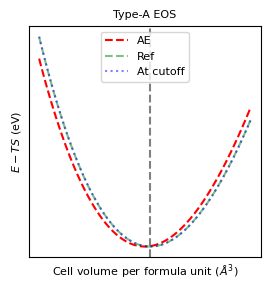

In [34]:
# type-A
import matplotlib.pyplot as plt
from pprint import pprint

A_node = orm.load_node(2274735)
data_plot = plot_compare_extract(A_node.pk)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
pprint(data_plot)
eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-A EOS")

{'AE_ref': [74.908047839837, 0.089508070391194, 6.4889598936674],
 'cutoff_eos': [75.0153291, 0.0846139, 6.7970157],
 'ref_200': [75.0280034, 0.0846364, 6.0949233]}


<Axes: title={'center': 'Type-B EOS'}, xlabel='Cell volume per formula unit ($\\AA^3$)', ylabel='$E - TS$ (eV)'>

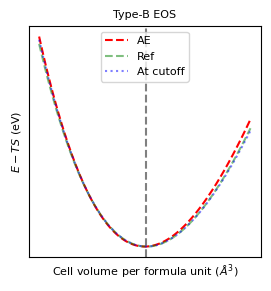

In [33]:
# type-B
B_node = orm.load_node(3710260)

data_plot = plot_compare_extract(B_node.pk)
pprint(data_plot)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-B EOS")

{'AE_ref': [55.258127917882, 0.23271882777448, 4.1760838426845],
 'cutoff_eos': [55.3150198, 0.2310179, 4.2827854],
 'ref_200': [55.3153274, 0.2317345, 4.2173494]}


<Axes: title={'center': 'Type-B EOS'}, xlabel='Cell volume per formula unit ($\\AA^3$)', ylabel='$E - TS$ (eV)'>

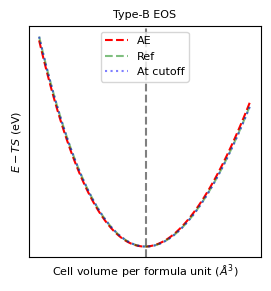

In [35]:
# type-B
B_node = orm.load_node(2274671)

data_plot = plot_compare_extract(B_node.pk)
pprint(data_plot)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-B EOS")

{'AE_ref': [43.564, 1.247527878045, 5.0059],
 'cutoff_eos': [43.7648042, 1.249672, 4.8675099],
 'ref_200': [43.7610456, 1.2485726, 4.8823621]}
'nu_200_ae - nu_cutoff_ae: 0.0087'
'nu_200_cutoff: 0.0097 nu_200_ae: 0.4514 nu_cutoff_ae: 0.4600'
{'AE_ref': [42.491860742974, 0.94162276579788, 4.3442113655204],
 'cutoff_eos': [42.5391568, 0.9403637, 4.3236311],
 'ref_200': [42.5370948, 0.9406874, 4.3380292]}
'nu_200_ae - nu_cutoff_ae: 0.0049'
'nu_200_cutoff: 0.0052 nu_200_ae: 0.1065 nu_cutoff_ae: 0.1115'
{'AE_ref': [43.193554798992, 1.1503058052012, 5.0250645420333],
 'cutoff_eos': [43.5583117, 1.1332683, 5.0564421],
 'ref_200': [43.5546708, 1.1333007, 5.0535206]}
'nu_200_ae - nu_cutoff_ae: 0.0083'
'nu_200_cutoff: 0.0084 nu_200_ae: 0.8359 nu_cutoff_ae: 0.8442'


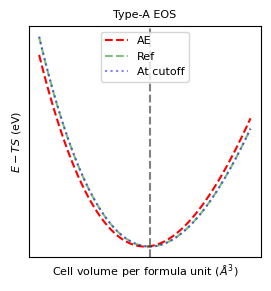

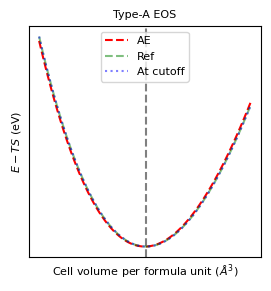

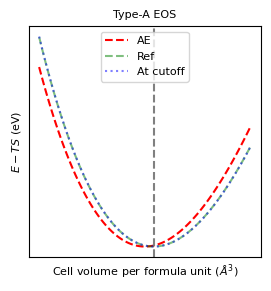

In [47]:
for n in [3709422, 3709860, 3710551]:
    B_node = orm.load_node(n)

    data_plot = plot_compare_extract(B_node.pk)
    pprint(data_plot)
    nu_200_cutoff = rel_errors_vec_length(*data_plot['ref_200'], *data_plot['cutoff_eos'])
    nu_200_ae = rel_errors_vec_length(*data_plot['ref_200'], *data_plot['AE_ref'])
    nu_cutoff_ae = rel_errors_vec_length(*data_plot['cutoff_eos'], *data_plot['AE_ref'])

    delta_nu = abs(nu_200_ae - nu_cutoff_ae)

    pprint(f"nu_200_ae - nu_cutoff_ae: {delta_nu:.4f}")
    pprint(f"nu_200_cutoff: {nu_200_cutoff:.4f} nu_200_ae: {nu_200_ae:.4f} nu_cutoff_ae: {nu_cutoff_ae:.4f}")


    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-A EOS")

{'AE_ref': [38.354318769204, 0.34038061482196, 5.0303793429724],
 'cutoff_eos': [38.9022242, 0.3497469, 4.636557],
 'ref_200': [38.8997297, 0.3482136, 4.7752857]}
'nu_200_ae - nu_cutoff_ae: 0.0084'
'nu_200_cutoff: 0.0240 nu_200_ae: 1.4166 nu_cutoff_ae: 1.4250'
{'AE_ref': [57.033456389566, 0.288670550222, 3.7832211891876],
 'cutoff_eos': [57.0475546, 0.2857748, 3.4188267],
 'ref_200': [57.0320072, 0.2854958, 3.4349187]}
'nu_200_ae - nu_cutoff_ae: 0.0012'
'nu_200_cutoff: 0.0277 nu_200_ae: 0.0604 nu_cutoff_ae: 0.0616'
{'AE_ref': [74.908047839837, 0.089508070391194, 6.4889598936674],
 'cutoff_eos': [75.0153291, 0.0846139, 6.7970157],
 'ref_200': [75.0280034, 0.0846364, 6.0949233]}
'nu_200_ae - nu_cutoff_ae: 0.0070'
'nu_200_cutoff: 0.0321 nu_200_ae: 0.3227 nu_cutoff_ae: 0.3156'


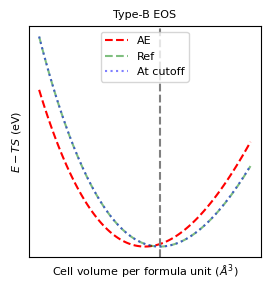

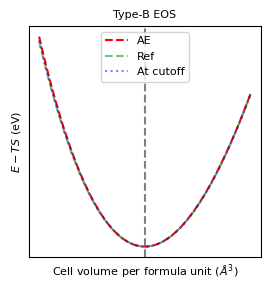

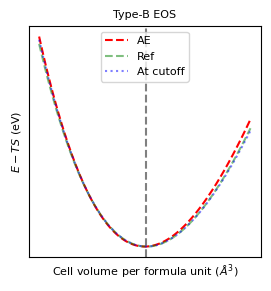

In [46]:
for n in [3709459, 3709570, 3710260]:
    B_node = orm.load_node(n)

    data_plot = plot_compare_extract(B_node.pk)
    pprint(data_plot)
    nu_200_cutoff = rel_errors_vec_length(*data_plot['ref_200'], *data_plot['cutoff_eos'])
    nu_200_ae = rel_errors_vec_length(*data_plot['ref_200'], *data_plot['AE_ref'])
    nu_cutoff_ae = rel_errors_vec_length(*data_plot['cutoff_eos'], *data_plot['AE_ref'])

    delta_nu = abs(nu_200_ae - nu_cutoff_ae)

    pprint(f"nu_200_ae - nu_cutoff_ae: {delta_nu:.4f}")
    pprint(f"nu_200_cutoff: {nu_200_cutoff:.4f} nu_200_ae: {nu_200_ae:.4f} nu_cutoff_ae: {nu_cutoff_ae:.4f}")


    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    eos_plot(ax, data_plot['AE_ref'], data_plot['ref_200'], data_plot['cutoff_eos'], title="Type-B EOS")
    fig.savefig(f"b-type/eos_{n}.png")